In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm

In [2]:
# Step 2: Load Dataset
df = pd.read_csv("economic_index.csv")
print(df.head())

   Unnamed: 0  year  month  interest_rate  unemployment_rate  index_price
0           0  2017     12           2.75                5.3         1464
1           1  2017     11           2.50                5.3         1394
2           2  2017     10           2.50                5.3         1357
3           3  2017      9           2.50                5.3         1293
4           4  2017      8           2.50                5.4         1256


In [3]:
# Step 3: Quick cleanup (drop index/year/month columns)
df.drop(columns=["Unnamed: 0", "month", "year"], axis=1, inplace=True)
print("\nAfter dropping extra columns:\n", df.head())


After dropping extra columns:
    interest_rate  unemployment_rate  index_price
0           2.75                5.3         1464
1           2.50                5.3         1394
2           2.50                5.3         1357
3           2.50                5.3         1293
4           2.50                5.4         1256


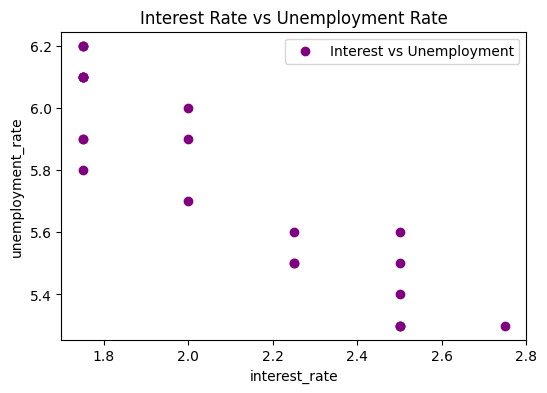

In [4]:
# Step 4: Visualization
plt.figure(figsize=(6,4))
plt.scatter(df["interest_rate"], df["unemployment_rate"], color='purple', label="Interest vs Unemployment")
plt.xlabel("interest_rate")
plt.ylabel("unemployment_rate")
plt.title("Interest Rate vs Unemployment Rate")
plt.legend()
plt.show()

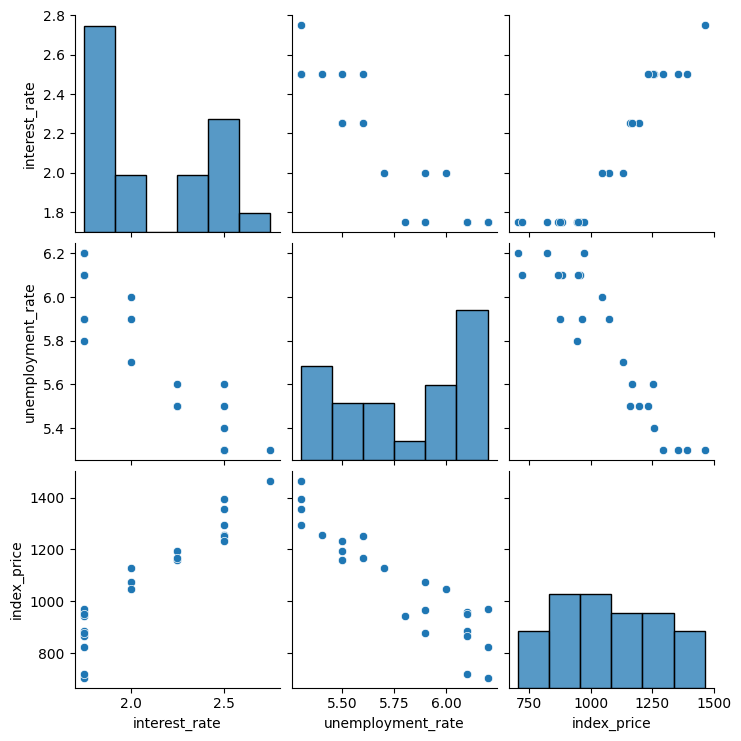

In [5]:
# Pairplot and pairwise regression plots (optional)
sns.pairplot(df)
plt.show()

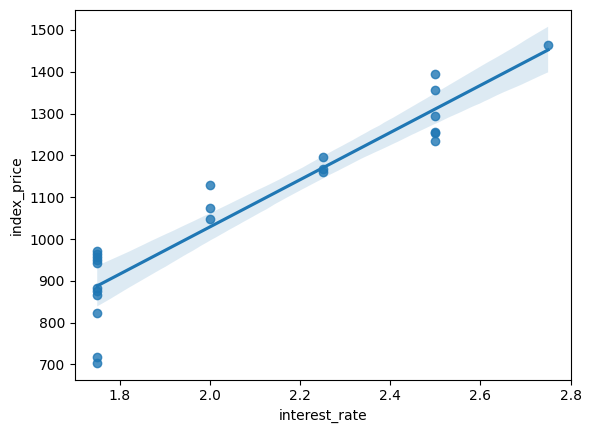

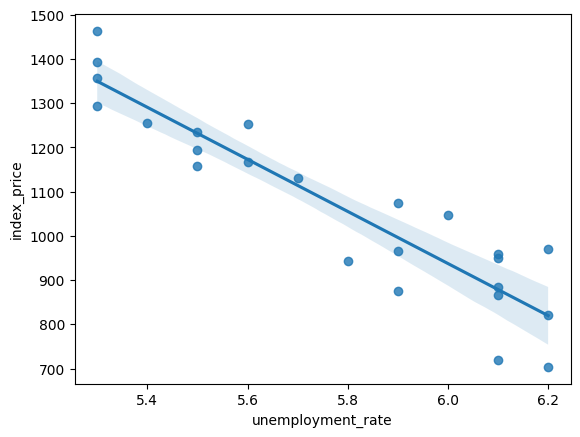

In [6]:
# Individual regplots vs index_price (optional)
sns.regplot(x="interest_rate", y="index_price", data=df)
plt.show()

sns.regplot(x="unemployment_rate", y="index_price", data=df)
plt.show()

In [7]:

# Step 5: Correlation & missing values check
print("\nCorrelation matrix:\n", df.corr())
print("\nMissing values:\n", df.isnull().sum())


Correlation matrix:
                    interest_rate  unemployment_rate  index_price
interest_rate           1.000000          -0.925814     0.935793
unemployment_rate      -0.925814           1.000000    -0.922338
index_price             0.935793          -0.922338     1.000000

Missing values:
 interest_rate        0
unemployment_rate    0
index_price          0
dtype: int64


In [ ]:
# Step 6: Define Independent & Dependent Variables
X = df[['interest_rate', 'unemployment_rate']]   # 2D DataFrame
Y = df['index_price']                             # 1D Series

In [9]:
# Step 7: Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)
print("\nTrain Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train Shape: (18, 2)
Test Shape: (6, 2)


In [10]:
# Step 8: Standardization (fit on train, transform on test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit on training set
X_test_scaled = scaler.transform(X_test)         # only transform test set (important!)

In [11]:
# Show scaled train (optional)
print("\nX_train_scaled sample:\n", X_train_scaled[:5])


X_train_scaled sample:
 [[-0.90115511  0.37908503]
 [ 1.31077107 -1.48187786]
 [-0.90115511  1.30956648]
 [ 1.31077107 -0.55139641]
 [ 1.31077107 -1.48187786]]


In [12]:
# Step 9: Train Model on Scaled Data
regression = LinearRegression()
regression.fit(X_train_scaled, Y_train)

print("\nCoefficients:", regression.coef_)
print("Intercept:", regression.intercept_)


Coefficients: [  88.27275507 -116.25716066]
Intercept: 1053.4444444444443


In [13]:
# Step 10: Cross-Validation (use negative MSE because sklearn's scorer convention)
# We run CV on the scaled training data
cv_scores_neg_mse = cross_val_score(
    regression, X_train_scaled, Y_train, scoring="neg_mean_squared_error", cv=3
)

In [14]:
# Convert to positive MSE values
cv_mse = -cv_scores_neg_mse
print("\nCross-Validation MSE (per fold):", cv_mse)
print("Mean CV MSE:", np.mean(cv_mse))
print("Std CV MSE:", np.std(cv_mse))


Cross-Validation MSE (per fold): [4921.61331265 7686.87497294 5135.9962549 ]
Mean CV MSE: 5914.828180162386
Std CV MSE: 1256.0791876080773


In [15]:
# If you prefer RMSE:
cv_rmse = np.sqrt(cv_mse)
print("Mean CV RMSE:", np.mean(cv_rmse))

Mean CV RMSE: 76.49830049161146


In [16]:
# Step 11: Predictions (on scaled test data)
Y_pred = regression.predict(X_test_scaled)

In [ ]:
# Compare Actual vs Predicted in a DataFrame
results = pd.DataFrame({
    "Actual_index_price": Y_test.values,
    "Predicted_index_price": Y_pred
})
print("\nComparison (test set):\n", results)


Comparison (test set):
    Actual_index_price  Predicted_index_price
0                1159            1204.227704
1                 971             821.650519
2                1464            1406.513004
3                 884             857.708896
4                1075             994.909923
5                1167            1168.169327


In [18]:
# Step 12: Performance Metrics
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("\nMSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)


MSE: 5793.762887712569
MAE: 59.935781523235484
RMSE: 76.11677139574805
R2 Score: 0.8278978091457145


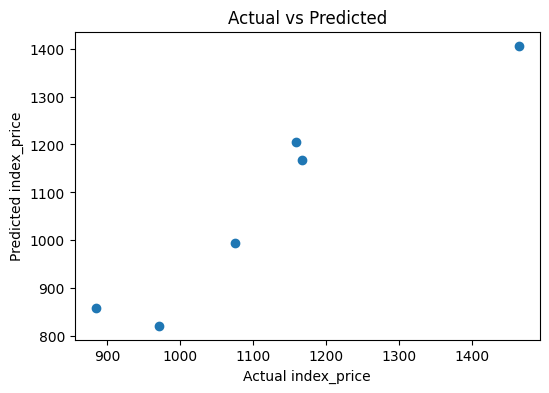

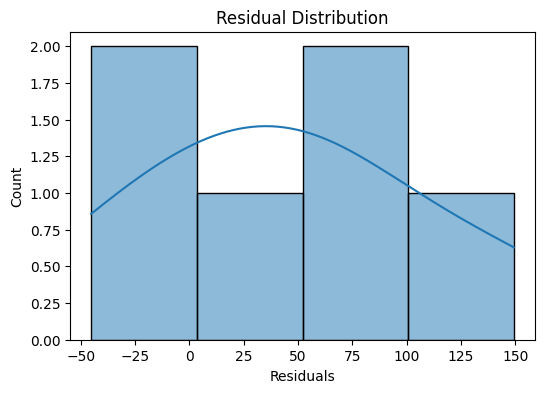

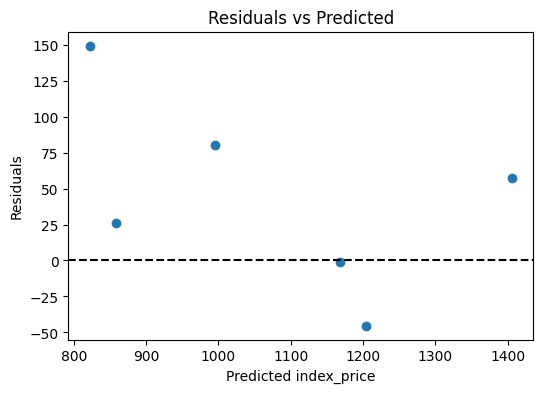

In [19]:
# Step 13: Residual analysis (diagnostics)
residuals = Y_test - Y_pred

plt.figure(figsize=(6,4))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual index_price")
plt.ylabel("Predicted index_price")
plt.title("Actual vs Predicted")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(Y_pred, residuals)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Predicted index_price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

In [20]:
# Print residuals (optional)
print("\nResiduals (sample):\n", residuals)


Residuals (sample):
 8     -45.227704
16    149.349481
0      57.486996
18     26.291104
11     80.090077
9      -1.169327
Name: index_price, dtype: float64


In [ ]:
# Step 14: OLS Regression with Intercept using statsmodels
# Important: add a constant so OLS estimates an intercept (otherwise R^2 is uncentered)
X_train_ols = sm.add_constant(X_train_scaled)  # adds intercept column named 'const'
ols_model = sm.OLS(Y_train, X_train_ols).fit()
print("\nOLS Summary:\n")
print(ols_model.summary())


OLS Summary:

                            OLS Regression Results                            
Dep. Variable:            index_price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     69.88
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           2.50e-08
Time:                        13:50:10   Log-Likelihood:                -100.85
No. Observations:                  18   AIC:                             207.7
Df Residuals:                      15   BIC:                             210.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1053.4444     16.941     

In [22]:
# Step 15: Predict for new data example (interest_rate=2.6, unemployment_rate=5.1)
new_data = pd.DataFrame([[2.6, 5.1]], columns=["interest_rate", "unemployment_rate"])
new_data_scaled = scaler.transform(new_data)
new_prediction = regression.predict(new_data_scaled)[0]
print("\nPredicted index_price for new data (2.6, 5.1):", new_prediction)


Predicted index_price for new data (2.6, 5.1): 1439.5791941064851
